In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.anova as sma
import numpy as np
from scipy.stats import pearsonr
import pingouin as pg
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")
plt.rcParams['svg.fonttype'] = 'none'



# Functions

In [2]:
# ------------------------------------------------------------------------------------------------------------
# Cleaning functions
# ------------------------------------------------------------------------------------------------------------

def get_max_payoff(f1, f2, cost1=0, cost2=0):
    """
    TODO: clean this up (check it works)
    """
    # data = np.zeros((11-cost2, 11-cost1))
    # for i in range(11-cost1):
        # for j in range(11-cost2):
            # data[j, i] = 10 - i - cost1 + ((i*f1 + j*f2)/2)
    # same algorithm as above but vectorized
    #data = 10 - np.arange(11-cost1) - cost1 + ((np.arange(11-cost1)[:, None]*f1 + np.arange(11-cost2)[None, :]*f2)/2)
    # Create arrays of indices
    i, j = np.indices((int(11-cost1), int(11-cost2)))

    # Compute data array
    data = 10 - i - cost1 + ((i*f1 + j*f2)/2)

    # Transpose data array to match original code
    data = data.T

    return np.amax(data), np.amin(data)


def normalize_payoff(df, with_group, cost=0):
    """
    TODO: clean this up
    """
    f1 = df['multiplier'].unique()[0]
    f2 = df['multiplier'].unique()[1]
    # matching = {}
    # for m1, m2 in ((f1, f2), (f1, f1), (f2, f1), (f2, f2)):
        # matching[(m1, m2)] = {'max': {f1: get_max_payoff(m1, m2, cost)[0], f2: get_max_payoff(m2, m1, cost)[0]},
                            #   'min': {f1: get_max_payoff(m1, m2, cost)[1], f2: get_max_payoff(m2, m1, cost)[1]}}
    
    def func_f1(x):
        # print(x)
        # print('min=', get_max_payoff(x.multiplier, x.opp_multiplier, cost*x.disclose, cost*x.opp_disclose)[1])
        # print('max=', get_max_payoff(x.multiplier, x.opp_multiplier, cost*x.disclose, cost*x.opp_disclose)[0])
        return (x.payoff - get_max_payoff(x.multiplier, x.opp_multiplier, cost*x.disclose, cost*x.opp_disclose)[1]) / \
        (get_max_payoff(x.multiplier, x.opp_multiplier, cost*x.disclose, cost*x.opp_disclose)[0] - \
        get_max_payoff(x.multiplier, x.opp_multiplier, cost*x.disclose, cost*x.opp_disclose)[1])
    
    def func_f2(x):
        return (x.opp_payoff - get_max_payoff(x.opp_multiplier, x.multiplier, cost*x.opp_disclose, cost*x.disclose)[1]) / \
        (get_max_payoff(x.opp_multiplier, x.multiplier, cost*x.opp_disclose, cost*x.disclose)[0] - \
        get_max_payoff(x.opp_multiplier, x.multiplier, cost*x.opp_disclose, cost*x.disclose)[1])
    
    def func_f3(x):
        # print(x)
        opp = get_opp(df, x.group_id, x.name)
        max_, min_ = get_max_payoff(x.multiplier,
         opp.multiplier.values[0], cost*x.disclose, cost*opp.disclose.values[0])

        # x1 = (x.payoff - get_max_payoff(x.multiplier, opp.multiplier, cost*x.disclose, cost*opp.disclose)[1]) / \
        # (get_max_payoff(x.multiplier, opp.multiplier, cost*x.disclose, cost*opp.disclose)[0] - \
        # get_max_payoff(x.multiplier, opp.multiplier, cost*x.disclose, cost*opp.disclose)[1])
        return (x.payoff - min_) / (max_ - min_)
    
    #norm = lambda x: (x - min) / (max - min)
    if with_group:
        df['norm_payoff'] = df.apply(func=func_f3, axis=1)
        # df['avg_norm_payoff'] = (df['norm_payoff'] + df['opp_norm_payoff']) / 2
    else:
        df['norm_payoff'] = df.apply(func=func_f1, axis=1)
        df['opp_norm_payoff'] = df.apply(func=func_f2, axis=1)
        df['avg_norm_payoff'] = (df['norm_payoff'] + df['opp_norm_payoff']) / 2
    return df

def correct_norm_payoff(df, with_group):
    # because of rounding errors, some values are slightly above 1
    if df.norm_payoff.max() > 1:
        df.loc[df.norm_payoff > 1, 'norm_payoff'] = 1
    return df

def get_opp(df, group_id, idx):
    return df[df['group_id'] == group_id].drop(idx)

def add_max_payoff(df, cost=None, with_group=True):
    if with_group:
        group_ids = df['group_id'].unique()
    f1, f2 = sorted(df['multiplier'].unique())
    df['max_payoff'] = np.NaN
    matching = {}
    for m1, m2 in ((f1, f2), (f1, f1), (f2, f1), (f2, f2)):
        matching[(m1, m2)] = [get_max_payoff(m1, m2), get_max_payoff(m2, m1)]

    if not with_group:
        for i, d in df.iterrows():
            t1 = d['multiplier']
            t2 = d['opp_multiplier']
            c1 = int(d['disclose'])
            c2 = int(d['opp_disclose'])

            max_payoff = matching[t1, t2]

            if cost:
                max_payoff = [get_max_payoff(t1, t2, cost1=cost*c1, cost2=c2*cost),
                              get_max_payoff(t2, t1, cost1=cost*c2, cost2=c1*cost)]

            df.loc[i, 'max_payoff'] = max_payoff[0]
            df.loc[i, 'opp_max_payoff'] = max_payoff[1]
        return df 


    for g in group_ids:
        d = df[df['group_id'] == g]
        if len(d) == 2:
            idx = d.index.tolist()
            t1 = d.iloc[0]['multiplier']
            t2 = d.iloc[1]['multiplier']
            c1 = d.iloc[0]['disclose']
            c2 = d.iloc[1]['disclose']

            max_payoff = matching[t1, t2]

            if cost:
                max_payoff = [get_max_payoff(t1, t2, cost1=cost*c1, cost2=c2*cost),
                              get_max_payoff(t2, t1, cost1=cost*c2, cost2=c1*cost)]

            df.loc[idx[0], 'max_payoff'] = max_payoff[0]
            df.loc[idx[1], 'max_payoff'] = max_payoff[1]
    return df


def add_norm_payoff(df, with_opp):
    df['norm_payoff'] = df['payoff']/df['max_payoff']
    if with_opp:
        df['opp_norm_payoff'] = df['opp_payoff']/df['opp_max_payoff']
    return df

def add_norm_contribution(df, cost):
    df['norm_contribution'] = df['contribution']/(10 - df['disclose']*cost)
    return df


def remove_bots(df, threshold=None):
    if threshold:
        ids = df[df.rt1!=-1].prolific_id.unique()
        groups = df[df.prolific_id.isin(ids)].group_id
        df2 = df[df.group_id.isin(groups)].groupby('prolific_id', as_index=False).rt1.value_counts(normalize=True)
        df2.rt1 = df2.rt1.apply(lambda x: 'bot' if x==-1 else 'human')
        df2 = df2.groupby(['prolific_id', 'rt1'], as_index=False).sum()
        return df[df.prolific_id.isin(df2[((df2.rt1 == 'bot') & (df2.proportion<threshold)) | ((df2.rt1=='human') & (df2.proportion>(1-threshold)))].prolific_id)]

    prolific_id_to_exclude = df[df['rt1'] == -1]['prolific_id'].unique()
    df = df[~df['prolific_id'].isin(prolific_id_to_exclude)]
    return df


def add_subjects(df, num):
    df['id_in_session'] = df['id_in_session'] + (num*100)
    return df


def remove_bots_but_keep_previous_rows(df):
    return df[df['rt1'] != -1]


def remove_trials_where_both_players_are_bots(df):
    group_ids = df['group_id'].unique()
    for g in group_ids:
        d = df[df['group_id'] == g]
        idx = d.index.tolist()
        rt1 = d.iloc[0]['rt1'] == -1
        rt2 = d.iloc[1]['rt1'] == -1
        if rt1 and rt2:
            df = df.drop(idx)
    return df


def remove_incomplete_sub(df, n):
    count = 0
    for i in df['prolific_id'].unique():
        count += len(df[df['prolific_id'] == i]) == n
    # exclude prolific ids with incomplete data (!= n)
    df = df[df.prolific_id.isin(
        df.prolific_id.value_counts()[df.prolific_id.value_counts() == n].index)]
    return df, count

def add_social_welfare(df):
    df['social_welfare'] = df['payoff'] + df['opp_payoff']
    return df


In [ ]:
get_max_payoff(1.5, 2.5, 0, 0)

(22.5, 7.5)

# Data clearning

In [4]:
exp = [
    'data/' + f for f in
    ['theresa_sorting.csv',
     'theresa_control.csv',
     'theresa_with_cost.csv',
     'theresa_single.csv',
     'cost_single_final_58.csv',
     ]
]

dfs = [pd.read_csv(f) for f in exp]

for i, d in enumerate(dfs):
   print('Start treating Exp. ', i)
   if i in [3, 4]:
      dfs[i] = remove_bots(dfs[i].copy())
   # if i in [0, 1, 2]:
      # dfs[i] = remove_trials_where_both_players_are_bots(dfs[i].copy())

   dfs[i], count = remove_incomplete_sub(
        df=dfs[i].copy(), n=63 if i in [3, 4] else 60)
   dfs[i] = add_norm_contribution(df=dfs[i].copy(), cost= 2 if i in [2, 4] else 0)
   dfs[i] = normalize_payoff(dfs[i].copy(), with_group= i not in [3, 4], cost=2 if i in [2, 4] else 0)
   dfs[i] = correct_norm_payoff(dfs[i].copy(), None)
   
   dfs[i] = dfs[i][dfs[i].round_number>3].copy()
   dfs[i]['exp'] = i

   if i in [0, 1, 2]:
      # TODO: do something about this!!!!
      # TODO: CHECK IF THIS IS CORRECT
      dfs[i] = dfs[i][dfs[i].disclose!=-1].copy()
      dfs[i] = remove_bots(dfs[i].copy(), threshold=0.25)
      
   print(f'Exp {i}', f'N={count}', f'filename={exp[i]}')

full = pd.concat(dfs)
# df = pd.read_csv('data/cost_single_final_58.csv')
    # df['prolific_id']

#

Start treating Exp.  0
Exp 0 N=36 filename=data/theresa_sorting.csv
Start treating Exp.  1
Exp 1 N=30 filename=data/theresa_control.csv
Start treating Exp.  2
Exp 2 N=30 filename=data/theresa_with_cost.csv
Start treating Exp.  3
Exp 3 N=56 filename=data/theresa_single.csv
Start treating Exp.  4
Exp 4 N=46 filename=data/cost_single_final_58.csv


# Check sanity of the data

/tmp/ipykernel_161110/2887406872.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = d.groupby('prolific_id', as_index=False).mean()


<Axes: xlabel='exp', ylabel='norm_payoff'>

<Axes: xlabel='exp', ylabel='norm_payoff'>

(0.6166666666666667, 0.8018874476590394)

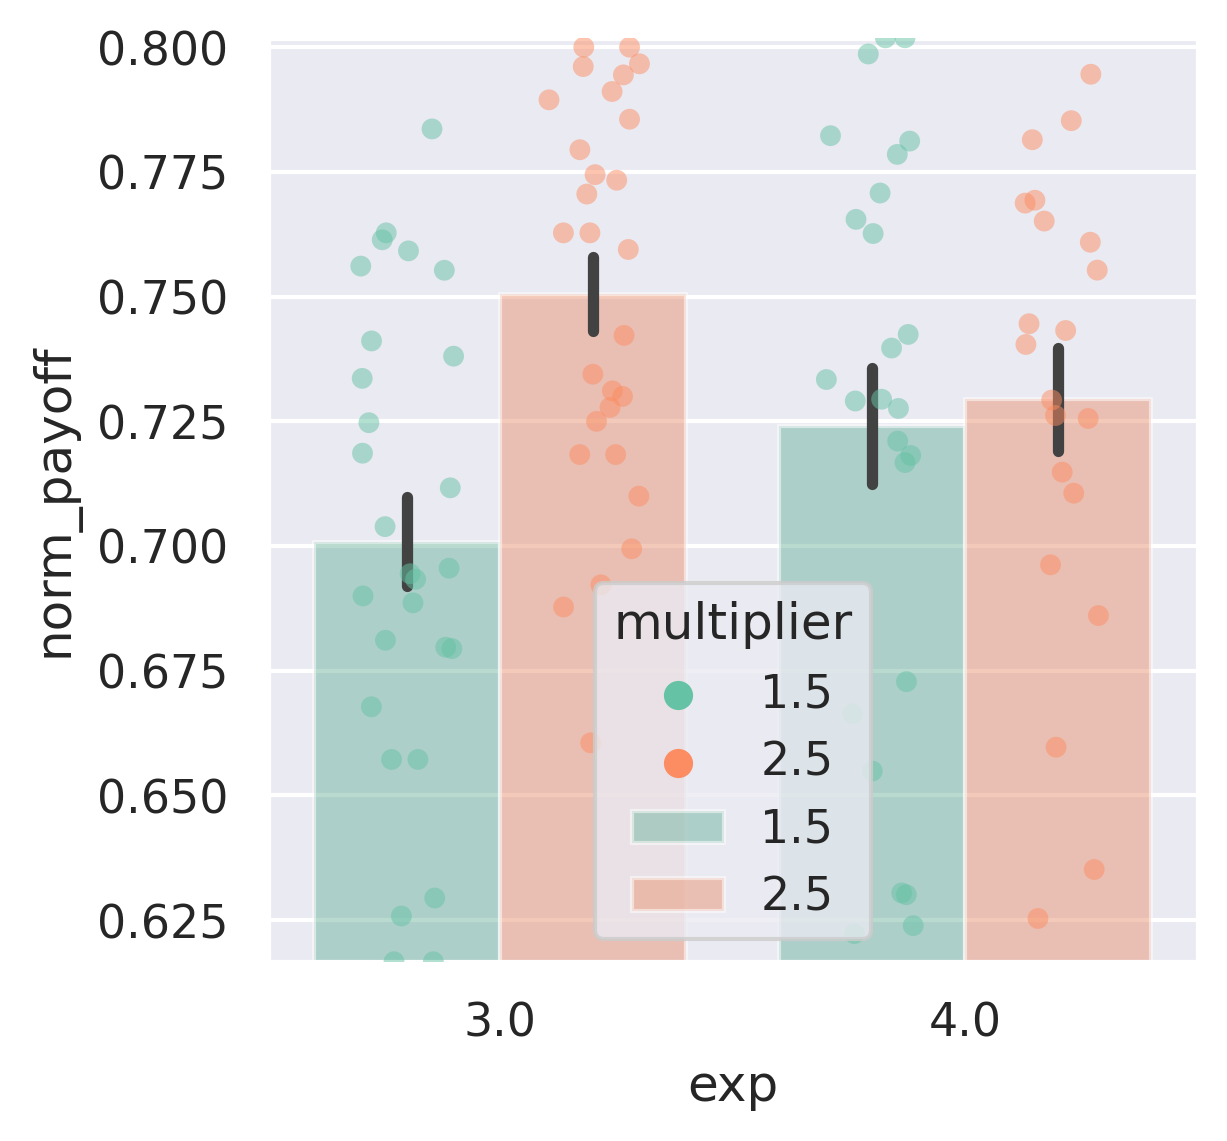

<Axes: xlabel='exp', ylabel='norm_payoff'>

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CovidGoodGameAnalysisLast/venv/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,exp,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,exp,-,3.0000,4.0000,False,True,-0.0982,5926.8217,two-sided,0.9218,NaN,NaN,0.029,-0.0025
1,multiplier,-,1.5000,2.5000,False,True,-3.3978,6003.1536,two-sided,0.0007,NaN,NaN,9.09,-0.0871
2,exp * multiplier,3,1.5000,2.5000,False,True,-4.2007,3358.0000,two-sided,0.0000,0.0001,bonf,247.994,-0.1449
3,exp * multiplier,4,1.5000,2.5000,False,True,-0.4130,2616.8162,two-sided,0.6797,1.0000,bonf,0.047,-0.0159


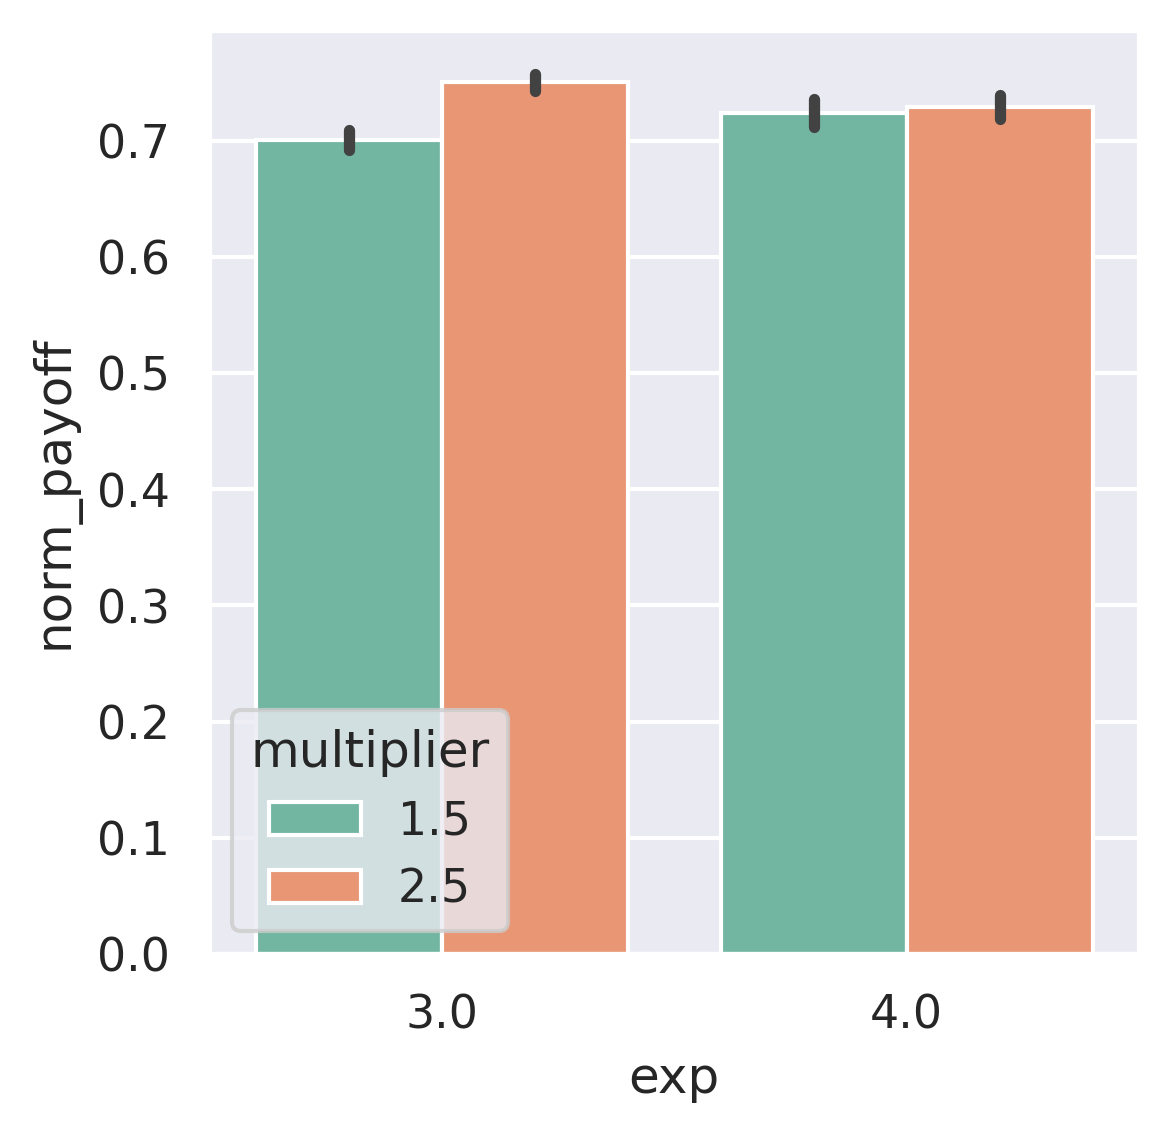

In [ ]:
data = full[full.exp.isin([4, 3])]
sns.set({'figure.figsize':(4, 4)})

# normalize norm_payoff between 0 and 1 
d = data.copy()
d = d.groupby('prolific_id', as_index=False).mean()
# d['norm_payoff'] = (d['norm_payoff'] - d['norm_payoff'].min()) / (d['norm_payoff'].max() - d['norm_payoff'].min())
# df2['norm_payoff'] = (df2.norm_payoff-df2.norm_payoff.min())/(df2.norm_payoff.max()-df2.norm_payoff.min())
sns.set_palette('Set2')

sns.barplot(x='exp', y='norm_payoff', hue='multiplier', data=d, errorbar='se', alpha=.5)
sns.stripplot(x='exp', y='norm_payoff', hue='multiplier', data=d, palette='Set2', dodge=True, alpha=.5, jitter=.2)
plt.ylim((d.norm_payoff.min(), d.norm_payoff.max()))
plt.show()


sns.barplot(x='exp', y='norm_payoff', hue='multiplier', data=d, errorbar='se')
#pg.anova(data=data, dv='norm_payoff', between=['multiplier', 'exp'], detailed=True)
pg.pairwise_ttests(data=data, dv='norm_payoff', between=['exp', 'multiplier'], padjust='bonf', effsize='cohen', subject='prolific_id')

In [ ]:
# check proportions of bots meeting per prolific_id
df = dfs[1].copy()
ids = df[df.rt1!=-1].prolific_id.unique()
groups = df[df.prolific_id.isin(ids)].group_id
df2 = df[df.group_id.isin(groups)].groupby('prolific_id', as_index=False).rt1.value_counts(normalize=True)
df2.rt1 = df2.rt1.apply(lambda x: 'bot' if x==-1 else 'human')

df2.groupby(['prolific_id', 'rt1'], as_index=False).sum()
# plt.title('Distribution of bots per prolific_id')
# plt.xlabel('proportion of bot trials')
# plt.ylabel('subject count')

,prolific_id,rt1,proportion
0,5702c03e68c641000e0d754d,human,1.000000
1,5d1a69d8f97a18001977e0d7,human,1.000000
2,5da9b30a3624c200157bd9f0,bot,0.181818
3,5da9b30a3624c200157bd9f0,human,0.818182
4,5dc5c4b99e40c94387aeb4e5,human,1.000000
5,5e9c29a39c157d14227afac8,human,1.000000
6,5ea936e503a71a000af12d7b,human,1.000000
7,5f97e6601f6d0e016087fc91,human,1.000000
8,5fb291cdd0a22f8b1fe4dca2,human,1.000000
9,5ff1c44bfef4d15dbc331ace,human,1.000000


/tmp/ipykernel_161110/3926077069.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fig1 = df.groupby('prolific_id').mean().multiplier.plot(kind='hist')
/tmp/ipykernel_161110/3926077069.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('prolific_id', as_index=True).mean().multiplier.value_counts()


1.5    25
2.5    21
Name: multiplier, dtype: int64

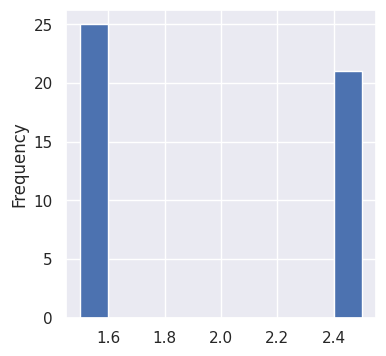

/tmp/ipykernel_161110/3926077069.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('prolific_id').mean().opp_multiplier.value_counts()


2.0    46
Name: opp_multiplier, dtype: int64

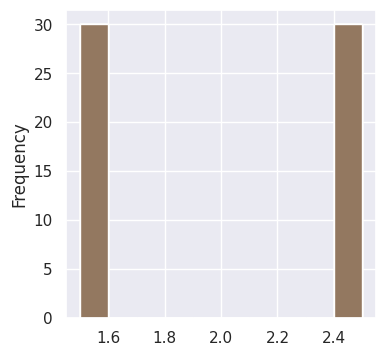

<Axes: xlabel='round_number', ylabel='opp_multiplier'>

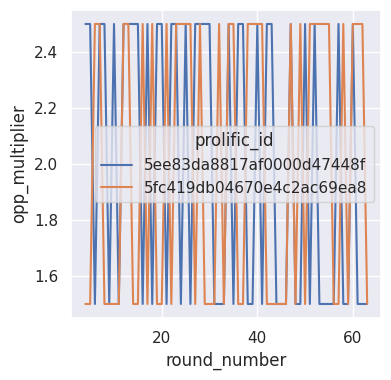

<Axes: xlabel='round_number', ylabel='opp_p_disclose'>

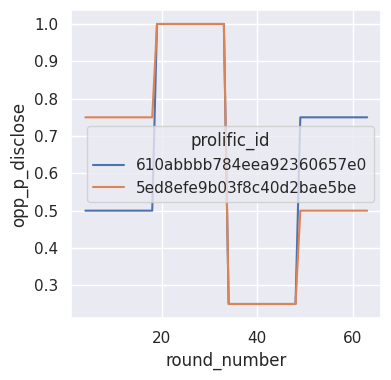

<Axes: xlabel='round_number', ylabel='opp_contribution'>

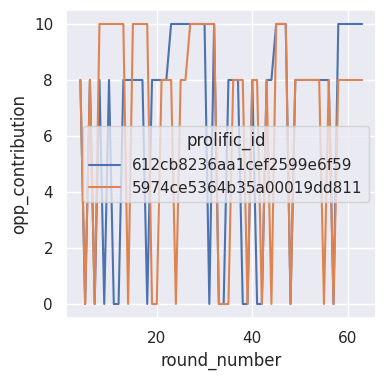

In [ ]:

df = dfs[4].copy()
df = df[df.round_number>3]

# we manipulate the player multiplier (50/50)
fig1 = df.groupby('prolific_id').mean().multiplier.plot(kind='hist')
df.groupby('prolific_id', as_index=True).mean().multiplier.value_counts()
plt.show()

# we manipulate the opposant multiplier (50/50), also it is randomized across trials
fig2 = df.groupby('prolific_id').opp_multiplier.plot(kind='hist')
df.groupby('prolific_id').mean().opp_multiplier.value_counts()
plt.show()
sns.lineplot(x='round_number', y='opp_multiplier', hue='prolific_id', data=df[df.prolific_id.isin(df.prolific_id.sample(2))])
plt.show()

# we manipulate the opp p disclose
sns.lineplot(x='round_number', y='opp_p_disclose', hue='prolific_id', data=df[df.prolific_id.isin(df.prolific_id.sample(2))])
plt.show()

# we manipulate the opp contribution decision
sns.lineplot(x='round_number', y='opp_contribution', hue='prolific_id', data=df[df.prolific_id.isin(df.prolific_id.sample(2))])
# plot(x='round_number', y='opp_multiplier', legend=True)
# sns.lineplot(x='round_number', y='disclose', hue='multiplier', data=df,ci=68)

# Learning 

<Axes: xlabel='round_number', ylabel='norm_payoff'>

(0.0, 1.0)

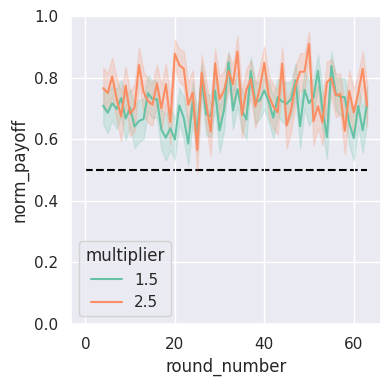

<Axes: xlabel='multiplier', ylabel='norm_payoff'>

(0.0, 1.0)

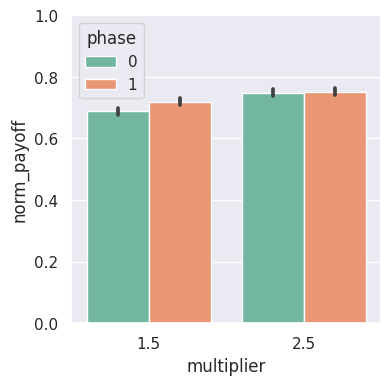

In [ ]:
selected_exp = 3
df = dfs[selected_exp].copy()

sns.set_palette('Set2')

vd = 'norm_payoff'
plt.plot([0, 63], [.5, .5], zorder=0, color='black', linestyle='--')
sns.lineplot(x='round_number', y=vd, hue='multiplier', data=df, errorbar='se', palette='Set2')
plt.ylim(0,1)
plt.show()

df = df[df.round_number>3]
df['phase'] = 1
df.loc[(df.round_number<33), 'phase'] = 0

sns.barplot(x='multiplier', y=vd, hue='phase', data=df, errorbar='se', palette='Set2')
plt.ylim(0,1)
plt.show()


# Variables Corr

               multiplier opp_p_disclose opp_multiplier disclose contribution  \
multiplier            0.0            1.0            1.0      0.0          0.0   
opp_p_disclose        1.0            0.0            1.0    0.781       0.2405   
opp_multiplier        1.0            1.0            0.0    0.924       0.0006   
disclose              0.0          0.781          0.924      0.0       0.6394   
contribution          0.0         0.2405         0.0006   0.6394          0.0   
norm_payoff        0.9488         0.8787            0.0   0.7395       0.1198   

               norm_payoff  
multiplier          0.9488  
opp_p_disclose      0.8787  
opp_multiplier         0.0  
disclose            0.7395  
contribution        0.1198  
norm_payoff            0.0  


/tmp/ipykernel_161110/3324045528.py:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = x.corr()


<Axes: >

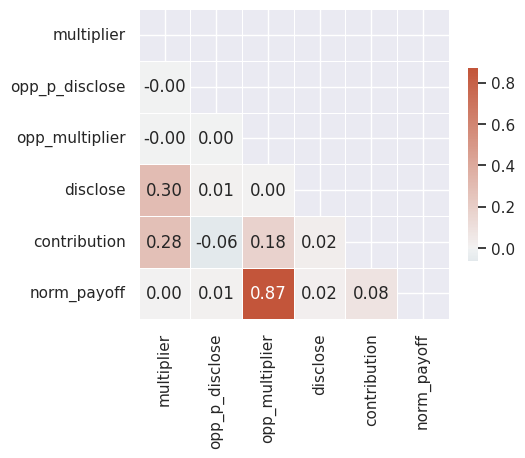

In [ ]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues



selected_exp = 4
df = dfs[selected_exp].copy()
# df = df[df['round_number'] < 30]

x = df.groupby(
    ['prolific_id','multiplier','opp_p_disclose', 'opp_multiplier'], as_index=False
    )[['disclose', 'contribution', 'norm_payoff']].mean()

# y = df.groupby(['prolific_id', 'multiplier' ], as_index=False)['contribution'].mean()

# Compute the correlation matrix
corr = x.corr()
p = calculate_pvalues(x)

print(p)

# combining text with values
# formatted_text = (np.asarray(["{0}\n{1:.2f}".format(
    # text, data) for text, data in zip(p.flatten(), corr.flatten())])).reshape(3, 5)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=corr, fmt=".2f")

#
#

# Variables corrtable

,X,Y,method,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,BF10,power
0,multiplier,disclose,pearson,two-sided,56,0.1549,"[-0.11, 0.4]",0.2542,1.0000,bonf,0.314,0.2085
1,multiplier,norm_contribution,pearson,two-sided,56,0.3754,"[0.12, 0.58]",0.0044,0.0653,bonf,8.758,0.8254
2,multiplier,contribution,pearson,two-sided,56,0.3754,"[0.12, 0.58]",0.0044,0.0653,bonf,8.758,0.8254
3,multiplier,norm_payoff,pearson,two-sided,56,0.4705,"[0.24, 0.65]",0.0003,0.0038,bonf,113.432,0.9630
4,multiplier,payoff,pearson,two-sided,56,0.9480,"[0.91, 0.97]",0.0000,0.0000,bonf,1.281e+25,1.0000
5,disclose,norm_contribution,pearson,two-sided,56,0.3707,"[0.12, 0.58]",0.0049,0.0737,bonf,7.875,0.8149
6,disclose,contribution,pearson,two-sided,56,0.3707,"[0.12, 0.58]",0.0049,0.0737,bonf,7.875,0.8149
7,disclose,norm_payoff,pearson,two-sided,56,0.0538,"[-0.21, 0.31]",0.6937,1.0000,bonf,0.18,0.0678
8,disclose,payoff,pearson,two-sided,56,0.1424,"[-0.13, 0.39]",0.2952,1.0000,bonf,0.284,0.1829
9,norm_contribution,contribution,pearson,two-sided,56,1.0000,"[1.0, 1.0]",0.0000,0.0000,bonf,inf,1.0000


,n,r,CI95%,p-val,BF10,power
pearson,56,0.3707,"[0.12, 0.58]",0.0049,7.875,0.8149


,n,r,CI95%,p-val,BF10,power
pearson,56,0.0150,"[-0.25, 0.28]",0.9126,0.168,0.0511


<Axes: xlabel='norm_contribution', ylabel='norm_payoff'>

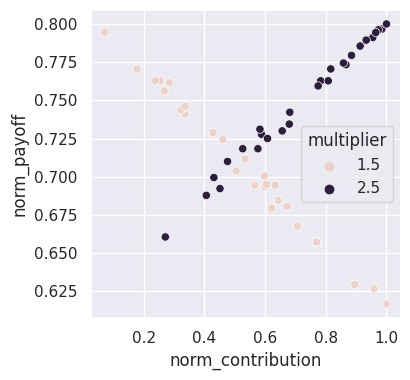

In [ ]:
selected_exp = 3
df = dfs[selected_exp].copy()
pd.options.display.float_format = '{:.4f}'.format
x = df.groupby(['prolific_id', 'multiplier'], as_index=False)[['disclose', 'norm_contribution', 'contribution', 'norm_payoff', 'payoff']].mean()
pg.pairwise_corr(data=x, padjust='bonf')
pg.corr(x['disclose'], x['norm_contribution'])
pg.corr(x['norm_payoff'], x['norm_contribution'])
sns.scatterplot(x='norm_contribution', y='norm_payoff', hue='multiplier', data=x)

In [ ]:
selected_exp = 4
df = dfs[selected_exp].copy()



Text(168.38055555555562, 0.5, 'payoff')

Text(0.5, 101.99999999999999, 'p(disclose)')

(0.6223202614379084, 0.8018874476590394)

Variable=norm_contribution


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      norm_contribution   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2.412
Date:                Mon, 15 May 2023   Prob (F-statistic):             0.0802
Time:                        19:55:55   Log-Likelihood:                -2.8290
No. Observations:                  46   AIC:                             13.66
Df Residuals:                      42   BIC:                             20.97
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.4478      0.070      6.414      0.000       0.307       0.589
C(multiplier)[T.2.5]              0.2463      0.115      2.151      0.037       0.015       0.477
disclose                          0.1856      0.351      0.529      0.599      -0.522       0.893
disclose:C(multiplier)[T.2.5]    -0.2299      0.421     -0.546      0.588      -1.080       0.620
==============================================================================
Omnibus:                        1.004   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.605   Jarque-Bera (JB):                0.980
Skew:                           0.191   Prob(JB):                        0.613
Kurtosis:                       2.396   Cond. No.                         15.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      norm_contribution   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     3.527
Date:                Mon, 15 May 2023   Prob (F-statistic):             0.0382
Time:                        19:55:55   Log-Likelihood:                -2.9916
No. Observations:                  46   AIC:                             11.98
Df Residuals:                      43   BIC:                             17.47
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.4680      0.059      7.969      0.000       0.350       0.586
C(multiplier)[T.2.5]     0.2052      0.086      2.398      0.021       0.033       0.378
disclose                 0.0262      0.193      0.136      0.892      -0.362       0.415
==============================================================================
Omnibus:                        1.154   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.562   Jarque-Bera (JB):                1.039
Skew:                           0.175   Prob(JB):                        0.595
Kurtosis:                       2.353   Cond. No.                         5.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      norm_contribution   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.176
Date:                Mon, 15 May 2023   Prob (F-statistic):              0.284
Time:                        19:55:55   Log-Likelihood:                -5.8786
No. Observations:                  46   AIC:                             15.76
Df Residuals:                      44   BIC:                             19.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5255      0.056      9.316      0.000       0.412       0.639
disclose       0.2030      0.187      1.084      0.284      -0.174       0.580
==============================================================================
Omnibus:                       10.129   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                2.736
Skew:                           0.017   Prob(JB):                        0.255
Kurtosis:                       1.806   Cond. No.                         4.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,44.0,3.477652,0.0,NaN,NaN,NaN
1,43.0,3.067408,1.0,0.410244,5.657038,0.021898
2,42.0,3.045807,1.0,0.021600,0.297858,0.588115


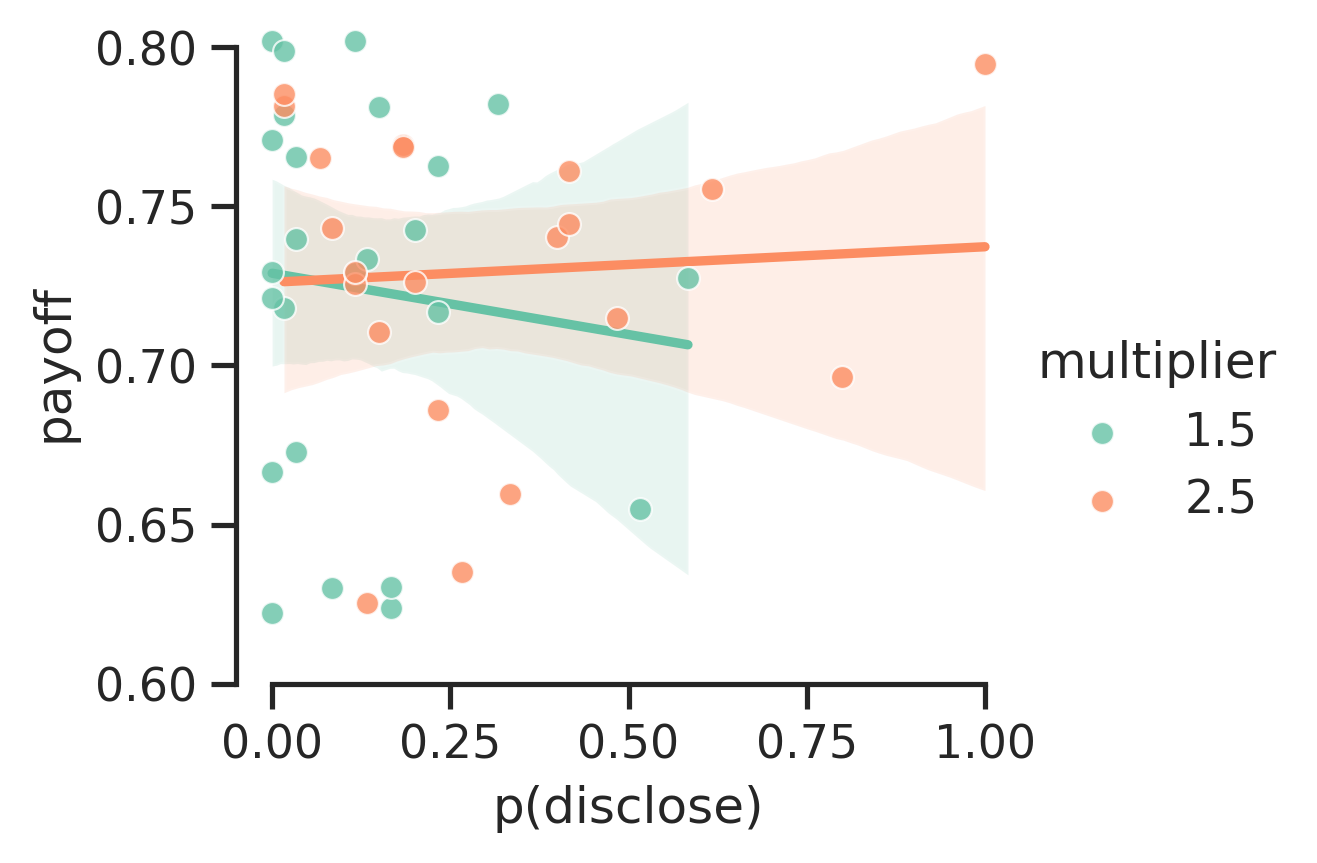

In [ ]:
selected_exp = 4
df = dfs[selected_exp].copy()
sns.set(rc={'figure.figsize':(3.75, 3)})
sns.set_style('ticks')
sns.set_palette('Set2')

vd = 'norm_payoff'
x = df.groupby(['prolific_id', 'multiplier'], as_index=False)[['disclose', 'norm_contribution', 'norm_payoff', 'payoff']].mean()
sns.lmplot(
   x='disclose', hue='multiplier',
   y=vd,  data=x, scatter_kws={'clip_on': False, 'zorder': 10, 
    'edgecolor': 'white', 'lw': .5, 's': 30}, aspect=3.75/3, height=3)
# plt.ylim(0,1)
# sns.despine(bottom=True)
plt.ylabel('payoff')
plt.xlabel('p(disclose)')

plt.ylim(df2.norm_payoff.min(), df2.norm_payoff.max())
ax = plt.gca()
ax.set_yticks([.6, .65, .7, .75, .8])
sns.despine(trim=True)  

# plt.tight_layout()
# sns.despine(right=True, top=True, trim=True)
# remove left spines and set smart bounds

plt.savefig(f'fig/fig3_exp_{selected_exp}_{vd}.svg')
# plt.show()
#
#
# x = df.groupby(['prolific_id', 'multiplier'], as_index=False)[['disclose', 'norm_contribution', 'norm_payoff', 'payoff']].mean()
# x['norm_payoff'] = (x.norm_payoff-x.norm_payoff.min())/(x.norm_payoff.max()-x.norm_payoff.min())


print('Variable=norm_contribution')
model1 = smf.ols(formula='norm_contribution ~ disclose * C(multiplier)', data=x).fit()
model2 = smf.ols(formula='norm_contribution ~ disclose + C(multiplier)', data=x).fit()
model3 = smf.ols(formula='norm_contribution ~ disclose', data=x).fit()

model1.summary()
model2.summary()
model3.summary()


sma.anova_lm(model3,model2, model1, typ=1)

#print('Variable=norm_payoff')
#model1 = smf.ols(formula='norm_payoff ~ disclose * C(multiplier)', data=x).fit()
#model2 = smf.ols(formula='norm_payoff ~ disclose + C(multiplier)', data=x).fit()
#model3 = smf.ols(formula='norm_payoff ~ disclose', data=x).fit()
#
#model1.summary()
#
#sma.anova_lm(model3, model2, model1, typ=1)


In [ ]:
selected_exp = 3
df = dfs[selected_exp].copy()
sns.set(rc={'figure.figsize': (3.75, 3)})
sns.set_style('ticks')
sns.set_palette('Set2')

vd = 'social_welfare'
x = df.groupby(['prolific_id', 'multiplier', 'opp_multiplier'], as_index=False)[
    ['disclose', 'social_welfare', 'avg_norm_payoff', 'norm_contribution', 'norm_payoff', 'payoff']].mean()
x['avg_norm_payoff'] = (x.avg_norm_payoff-x.avg_norm_payoff.min()) / \
    (x.avg_norm_payoff.max()-x.avg_norm_payoff.min())
sns.lmplot(
    x='disclose',
    y=vd, data=x, hue='multiplier', scatter_kws={'clip_on': False, 'zorder': 10,
                                                 'edgecolor': 'white', 'lw': .5, 's': 30}, aspect=3.75/3, height=3)
plt.ylabel(vd)
plt.xlabel('p(disclose)')
# remove left spines and set smart bounds
sns.despine(right=True, top=True, trim=True)

plt.savefig(f'fig/fig3_exp_wellfare_{selected_exp}_{vd}.svg')

print(f'Variable={vd}')
model1 = smf.ols(formula=f'{vd} ~ disclose * C(multiplier)', data=x).fit()
model2 = smf.ols(formula=f'{vd} ~ disclose + C(multiplier)', data=x).fit()
model3 = smf.ols(formula=f'{vd} ~ disclose', data=x).fit()

# model2.summary()
model2.summary()

sma.anova_lm(model3, model2, model1, typ=1)


KeyError: "Columns not found: 'social_welfare'"

# Logistic fit

Optimization terminated successfully.
         Current function value: 0.612702
         Iterations 5


/home/getz/PycharmProjects/CovidGoodGameAnalysisLast/venv/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['skip_hessian']
  warnings.warn(msg, ValueWarning)
/home/getz/PycharmProjects/CovidGoodGameAnalysisLast/venv/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['skip_hessian']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               disclose   No. Observations:                 3528
Model:                          Logit   Df Residuals:                     3524
Method:                           MLE   Df Model:                            3
Date:                Thu, 23 Feb 2023   Pseudo R-squ.:                 0.04628
Time:                        14:57:46   Log-Likelihood:                -2161.6
converged:                       True   LL-Null:                       -2266.5
Covariance Type:            nonrobust   LLR p-value:                 3.256e-45
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -0.1141      0.081     -1.401      0.161      -0.274       0.046
C(multiplier)[T.2.5]                      -0.1023      0.144     -0.711      0.477      -0.385       0.180
norm_contribution                          1.0604      0.126      8.429      0.000       0.814       1.307
norm_contribution:C(multiplier)[T.2.5]     0.5129      0.203      2.531      0.011       0.116       0.910
==========================================================================================================
"""

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

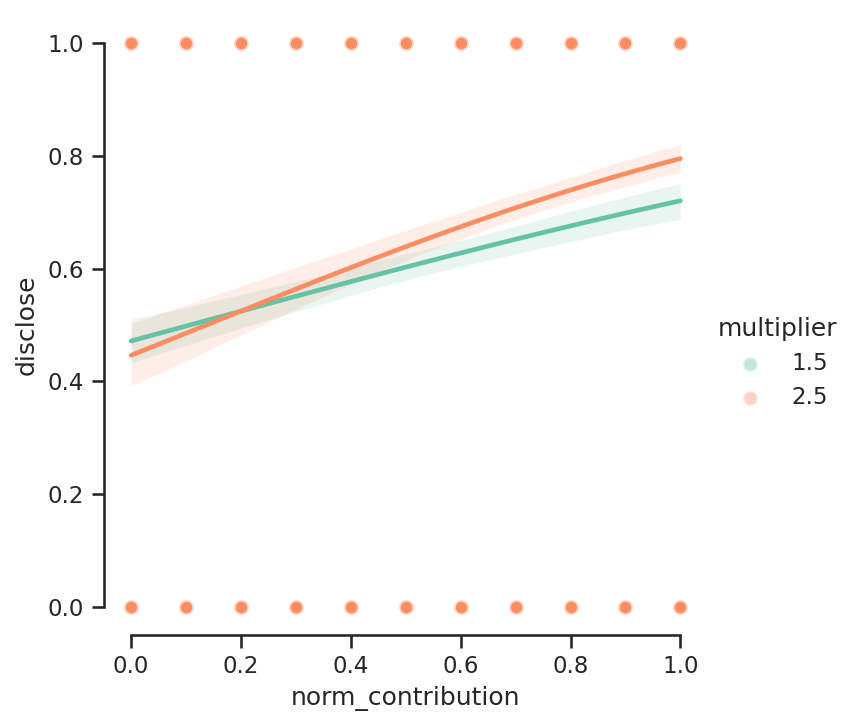

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               disclose   No. Observations:                 3528
Model:                          Logit   Df Residuals:                     3524
Method:                           MLE   Df Model:                            3
Date:                Thu, 23 Feb 2023   Pseudo R-squ.:                 0.04628
Time:                        14:57:51   Log-Likelihood:                -2161.6
converged:                       True   LL-Null:                       -2266.5
Covariance Type:            nonrobust   LLR p-value:                 3.256e-45
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -0.1141      0.081     -1.401      0.161      -0.274       0.046
C(multiplier)[T.2.5]                      -0.1023      0.144     -0.711      0.477      -0.385       0.180
norm_contribution                          1.0604      0.126      8.429      0.000       0.814       1.307
norm_contribution:C(multiplier)[T.2.5]     0.5129      0.203      2.531      0.011       0.116       0.910
==========================================================================================================
"""

In [ ]:
selected_exp = 3
df = dfs[selected_exp].copy()
vd = 'disclose'

model1 = smf.logit(formula='disclose ~ norm_contribution * C(multiplier)', data=df, skip_hessian=True).fit()
# model2 = smf.ols(formula='norm_payoff ~ disclose + multiplier', data=x).fit()
model1.summary()

# fig, axs = plt.subplots(1, 2)
sns.set_palette('Set2')
plt.figure(figsize=(8, 6))
sns.lmplot(
   x='norm_contribution',
   y=vd, hue='multiplier', data=df, 
   logistic=True,
   scatter_kws=dict(clip_on=False, zorder=10, alpha=.4, edgecolor='white', lw=1.5, s=50))
# plt.ylim(.7,1)
# plt.xlim(-1,11)
# remove left spines and set smart bounds
sns.despine(right=True, top=True, trim=True)
# plt.gca().spines['bottom'].set_smart_bounds(True)
plt.show()

model1.summary()

/tmp/ipykernel_1181560/1262385117.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(


<Axes: xlabel='multiplier', ylabel='disclose'>

(0.0, 1.0)

/tmp/ipykernel_1181560/1262385117.py:46: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.stripplot(


Text(0, 0.5, 'p(disclose)')

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.152433   54   two-sided  0.254219  [-0.29, 0.08]  0.308001  0.469   

           power  
T-test  0.204841  


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,multiplier,0.607639,1,54,0.607639,1.328102,0.254219,0.024004,NaN
1,opp_p_disclose,0.010536,3,162,0.003512,0.217792,0.883951,0.004017,0.951041
2,Interaction,0.042758,3,162,0.014253,0.883881,0.450821,0.016105,NaN


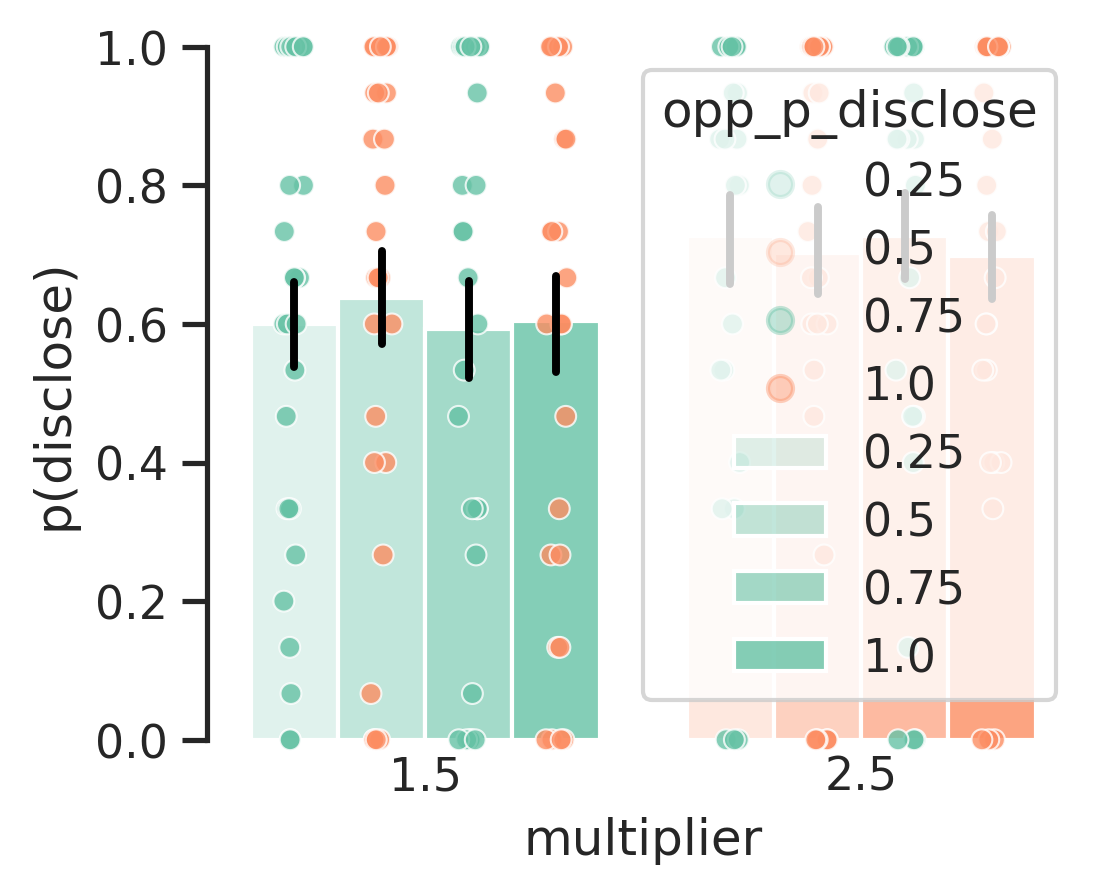

In [17]:
from matplotlib.colors import to_rgba, to_hex
selected_exp = 3
df = dfs[selected_exp]

vi = 'opp_p_disclose'
vd = 'disclose'

sns.set({'figure.figsize': (3.75, 3), 'figure.dpi': 300})
sns.set_style('ticks')

df2 = df.groupby(['prolific_id', 'multiplier',
                  vi], as_index=False)[vd].mean()


sns.set_palette("Set2")

alphas = np.linspace(0.2, .8, 4)
palette_green =[to_hex(to_rgba("C0", a), keep_alpha=True) for a in alphas]
palette_orange = [to_hex(to_rgba("C1", a), keep_alpha=True) for a in alphas]

palette = np.array([(i,j) for i,j in zip(palette_green, palette_orange)]).flatten()

# sns.set_palette(sns.color_palette(palette))

sns.barplot(
    x='multiplier',
    y=vd,
    hue=vi, data=df2, ci=68,
    edgecolor="white",
    errcolor="black",
    errwidth=1.9,
    # capsize=0.05,
    palette=list(palette),
    zorder=0, clip_on=False)

ax = plt.gca()  
count = 0
for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        bar.set_facecolor(palette[count])
        count+=1

plt.ylim(0, 1)
# return
# sns.pointplot()
ax = sns.stripplot(
    x='multiplier',
    y=vd, hue=vi, data=df2, dodge=True,
    jitter=True, 
    alpha=0.8, 
    size=5,
    palette=list(palette),
    edgecolor='white',
    linewidth=.5, zorder=1, clip_on=False)

# count = 0
# for i, bar_group in enumerate(ax.containers):
#     for bar in bar_group:
#         print(bar)
#         bar.set_facecolor(palette[count])
#         count+=1
# # 
sns.despine(right=True, top=True, trim=True, bottom=True)
plt.tick_params(axis='x', length=0)

plt.ylabel(f'p({vd})')

# plt.gca().spines['left'].set_smart_bounds(True)
# plt.gca().spines['bottom'].set_smart_bounds(True)

df3 = df.groupby(['prolific_id', 'multiplier'], as_index=False)[vd].mean()

r = pg.ttest(x=df3[df3['multiplier'] == 1.5][vd],
             y=df3[df3['multiplier'] == 2.5][vd])
# plt.ylim(.6, 1)
print(r)
pg.mixed_anova(data=df2, dv=vd, between="multiplier",
               within=vi, subject='prolific_id')

plt.savefig(f'fig/fig3_exp_{selected_exp}_p_disclose.svg')


In [ ]:
palette_green = np.array([to_hex(to_rgba("C0", a), keep_alpha=True) for a in alphas])
palette_orange = np.array([to_hex(to_rgba("C1", a), keep_alpha=True) for a in alphas])

palette = np.array([palette_green[:2], palette_orange[:2], palette_orange[2:], palette_green[2:]]).flatten()



In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
df2 = df.groupby(['prolific_id', 'opp_p_disclose', 'multiplier'], as_index=False)['disclose'].mean()

sns.set_palette("crest")
sns.barplot(x='multiplier', y='disclose', hue='opp_p_disclose', data=df2, ci=None, 
    edgecolor="white",
    # errcolor="black",
    # errwidth=1.5,
    # capsize = 0.05,
    alpha=0.5, ax=ax)
# sns.pointplot(x='multiplier', y='disclose', hue='opp_p_disclose', data=df2, ci=68,')

sns.stripplot(x='multiplier',y='disclose', hue='opp_p_disclose', data=df2, dodge=True, jitter=True, ax=ax, alpha=0.5, size=10, edgecolor='white', linewidth=1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[4:], title='opp_p_disclose', bbox_to_anchor=(1, 1.02), loc='upper left')
sns.despine(right=True, top=True)

plt.ylabel('average disclosure')

plt.gca().spines['left'].set_smart_bounds(True)
plt.gca().spines['bottom'].set_smart_bounds(True)



/tmp/ipykernel_735636/2036907683.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df[(df.round_number>3) & (df.rt1!=-1)].groupby(['prolific_id',  'multiplier'], as_index=False).mean()


(46,)

<Axes: >

<Axes: xlabel='multiplier', ylabel='disclose'>

/tmp/ipykernel_735636/2036907683.py:29: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_735636/2036907683.py:29: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.stripplot(


<Axes: xlabel='multiplier', ylabel='disclose'>

Text(0, 0.5, 'p(disclose)')

(0.0, 1.0)

Variable:  disclose
               T       dof alternative     p-val          CI95%   cohen-d  \
T-test -2.638468  31.75217   two-sided  0.012792  [-0.3, -0.04]  0.813794   

         BF10     power  
T-test  4.396  0.766955  


<Axes: >

<Axes: xlabel='multiplier', ylabel='norm_contribution'>

/tmp/ipykernel_735636/2036907683.py:61: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_735636/2036907683.py:61: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.stripplot(


<Axes: xlabel='multiplier', ylabel='norm_contribution'>

Text(0, 0.5, 'contribution')

(0.0, 1.0)

<Axes: >

<Axes: xlabel='multiplier', ylabel='norm_payoff'>

/tmp/ipykernel_735636/2036907683.py:93: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(
/tmp/ipykernel_735636/2036907683.py:93: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.stripplot(


Text(0, 0.5, 'payoff')

(0.6223202614379084, 0.8018874476590394)

/tmp/ipykernel_735636/2036907683.py:121: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,multiplier,1.5,2.5,False,True,-9.523357,42.020882,two-sided,4.699500e-12,1.78e+09,-2.828677


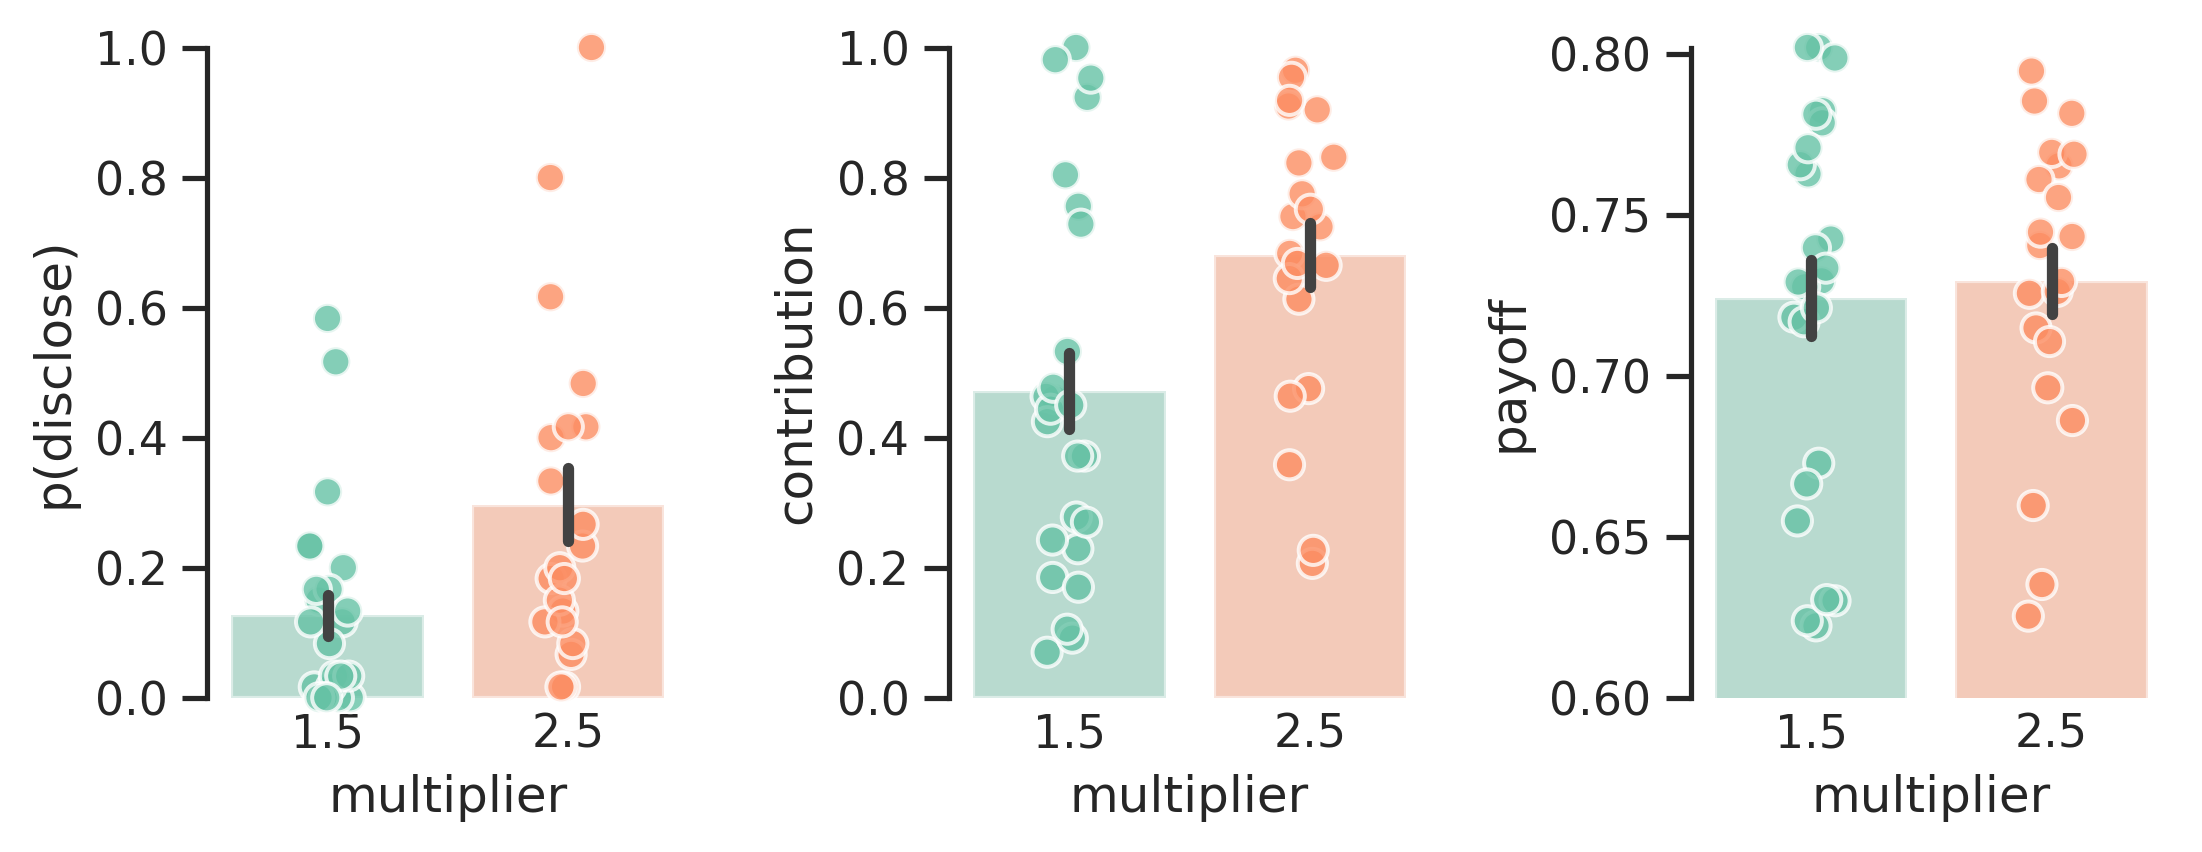

In [ ]:
selected_exp = 4
df = dfs[selected_exp].copy()


sns.set({'figure.figsize': (7.5, 3), 'figure.dpi': 300})

#sns.set_palette("Set2")
blue = '#053F5C'
yellow = '#F7AD19'
# sns.set_palette(palette=[blue, yellow])
sns.set_palette('Set2')
palette = sns.color_palette()
sns.set_style("ticks")

df2 = df[(df.round_number>3) & (df.rt1!=-1)].groupby(['prolific_id',  'multiplier'], as_index=False).mean()
df2.prolific_id.unique().shape
# df2['norm_payoff'] = (df2.norm_payoff-df2.norm_payoff.min())/(df2.norm_payoff.max()-df2.norm_payoff.min())

plt.subplot(1, 3, 1)
vd = 'disclose'
sns.barplot(x='multiplier', y=vd, data=df2, errorbar=('se'),
    edgecolor="white",
    # errcolor="black",
    # errwidth=1.5,
    # erralpha=0,
    # capsize = 0.05,
    alpha=0.5, zorder=0)

sns.stripplot(
    x='multiplier',
    y=vd,
    data=df2,
    alpha=0.8,
    size=7,
    linewidth=.95,
    edgecolor='white',
    zorder=1, palette=palette, clip_on=False)

plt.ylabel('p(disclose)')
sns.despine(trim=True, bottom=False)
plt.tick_params(axis='x', length=0)

plt.ylim(0, 1)
r = pg.ttest(x=df2[df2['multiplier'] == 1.5][vd],
    y=df2[df2['multiplier'] == 2.5][vd])
print('Variable: ', vd)
print(r)

# same plot for norm_contribution 
plt.subplot(1, 3, 2)
vd = 'norm_contribution'

sns.barplot(x='multiplier', y=vd, data=df2, errorbar=('se'),
    edgecolor="white",
    # errcolor="black",
    # errwidth=1.5,
    # erralpha=0,
    # capsize = 0.05,
    alpha=0.5, zorder=0)

sns.stripplot(
    x='multiplier',
    y=vd,
    data=df2,
    alpha=0.8,
    size=7,
    linewidth=.95,
    edgecolor='white',
    zorder=1, palette=palette, clip_on=False)

plt.ylabel('contribution')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)
# same plot for norm_payoff 
plt.ylim(0, 1)
# r = pg.ttest(x=df2[df2['multiplier'] == 1.5][vd],
    # y=df2[df2['multiplier'] == 2.5][vd])
# print('Variable: ', vd)
# print(r)


plt.subplot(1, 3, 3)
vd = 'norm_payoff'

sns.barplot(x='multiplier', y=vd, data=df2, errorbar='se',
    edgecolor="white",
    # errcolor="black",
    # errwidth=1.5,
    # erralpha=0,
    # capsize = 0.05,
    alpha=0.5, zorder=0)

ax = sns.stripplot(
    x='multiplier',
    y=vd,
    data=df2,
    # jitter=1,
    alpha=0.8,
    size=7,
    linewidth=.95,
    edgecolor='white',
    zorder=1, palette=palette, clip_on=False)


plt.ylabel('payoff')
plt.ylim(df2.norm_payoff.min(), df2.norm_payoff.max())
sns.despine(bottom=True)
ax.set_yticks([0.60, 0.65, 0.70, 0.75, 0.80])
plt.tick_params(axis='x', length=0)

# r = pg.ttest(x=df2[df2['multiplier'] == 1.5][vd],
    # y=df2[df2['multiplier'] == 2.5][vd])
# print('Variable: ', vd)
# print(r)


plt.tight_layout()
# plt.axis('equal')
plt.savefig(f'fig/fig2_exp_{selected_exp}.svg')

df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()
pg.pairwise_tests(data=df2, dv='payoff', between='multiplier',  padjust='bonferroni', effsize='cohen')


/tmp/ipykernel_1181560/162603549.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = full.groupby(['exp', 'prolific_id'], as_index=False).mean()


<Axes: >

<Axes: xlabel='exp', ylabel='disclose'>

/tmp/ipykernel_1181560/162603549.py:26: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.stripplot(


<Axes: xlabel='exp', ylabel='disclose'>

Text(0, 0.5, 'p(disclose)')

([<matplotlib.axis.XTick at 0x7fe74d6c2be0>,
 [Text(0, 0, 'free'), Text(1, 0, 'costly')])

(0.0, 1.0)

Variable:  disclose
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test -2.125178  99.542082   two-sided  0.036047  [-0.3, -0.01]  0.420981   

         BF10     power  
T-test  1.526  0.557204  


<Axes: >

<Axes: xlabel='exp', ylabel='norm_contribution'>

/tmp/ipykernel_1181560/162603549.py:65: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.stripplot(


<Axes: xlabel='exp', ylabel='norm_contribution'>

Text(0, 0.5, 'contribution')

(0.0, 1.0)

([<matplotlib.axis.XTick at 0x7fe74d64d730>,
 [Text(0, 0, 'free'), Text(1, 0, 'costly')])

<Axes: >

<Axes: xlabel='exp', ylabel='norm_payoff'>

/tmp/ipykernel_1181560/162603549.py:102: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.stripplot(


Text(0, 0.5, 'payoff')

(0.6166666666666667, 0.8018874476590394)

([<matplotlib.axis.XTick at 0x7fe74d62e4c0>,
 [Text(0, 0, 'free'), Text(1, 0, 'costly')])

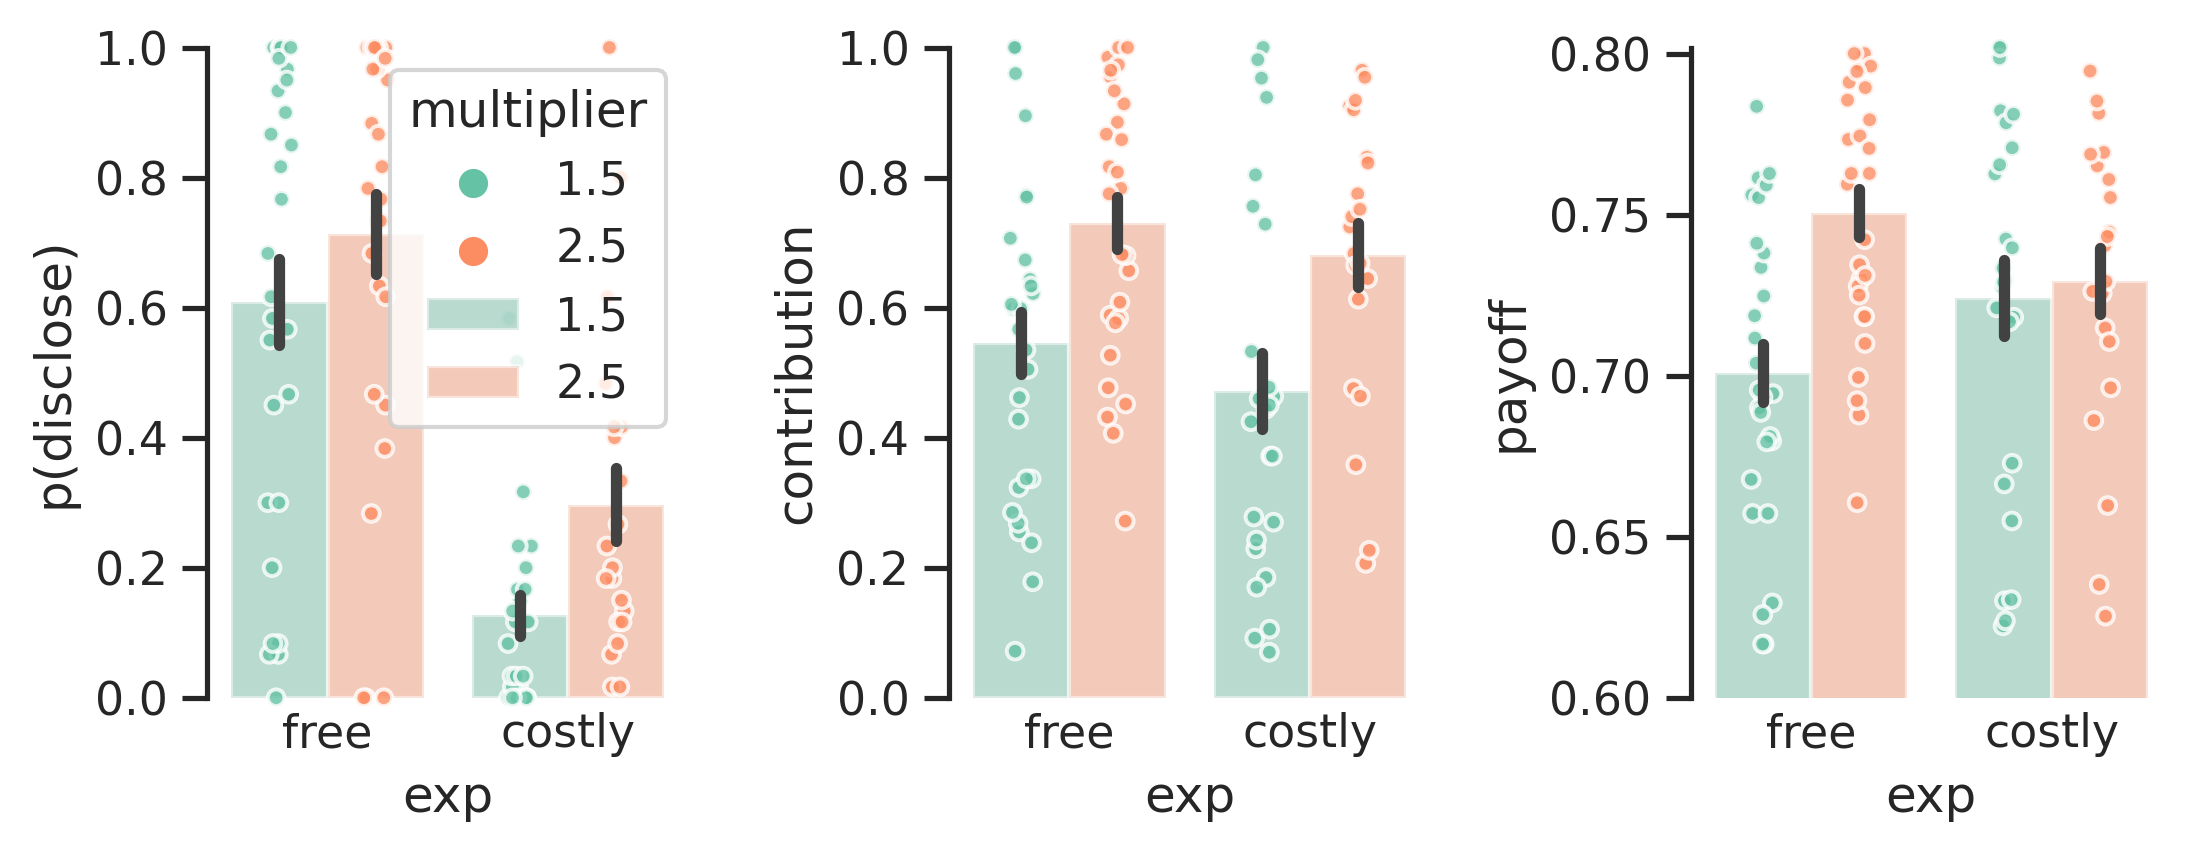

In [14]:
sns.set({'figure.figsize': (7.5, 3), 'figure.dpi': 300})

#sns.set_palette("Set2")
blue = '#053F5C'
yellow = '#F7AD19'
# sns.set_palette(palette=[blue, yellow])
sns.set_palette('Set2')
palette = sns.color_palette()
sns.set_style("ticks")

# df2 = df[(df.round_number>3) & (df.rt1!=-1)].groupby(['prolific_id',  'multiplier'], as_index=False).mean()
df2 = full.groupby(['exp', 'prolific_id'], as_index=False).mean()
df2 = df2[df2.exp.isin([3,4])]
# df2['norm_payoff'] = (df2.norm_payoff-df2.norm_payoff.min())/(df2.norm_payoff.max()-df2.norm_payoff.min())

plt.subplot(1, 3, 1)
vd = 'disclose'
sns.barplot(x='exp', hue='multiplier', y=vd, data=df2, errorbar=('se'),
    edgecolor="white",
    # errcolor="black",
    # errwidth=1.5,
    # erralpha=0,
    # capsize = 0.05,
    alpha=0.5, zorder=0)

sns.stripplot(
    hue='multiplier',
    x='exp',
    y=vd,
    data=df2,
    alpha=0.8,
    size=4,
    dodge=True,
    linewidth=.95,
    edgecolor='white',
    zorder=1, palette=palette, clip_on=False)

plt.ylabel('p(disclose)')
sns.despine(trim=True, bottom=False)
plt.tick_params(axis='x', length=0)

plt.tick_params(axis='x', length=0)
plt.xticks([0, 1], ['free', 'costly'])    

plt.ylim(0, 1)
r = pg.ttest(x=df2[df2['multiplier'] == 1.5][vd],
    y=df2[df2['multiplier'] == 2.5][vd])
print('Variable: ', vd)
print(r)

# plt.legend([],[], frameon=False)

# same plot for norm_contribution 
plt.subplot(1, 3, 2)
vd = 'norm_contribution'

sns.barplot(x='exp', hue='multiplier', y=vd, data=df2, errorbar=('se'),
    edgecolor="white",
    # errcolor="black",
    # errwidth=1.5,
    # erralpha=0,
    # capsize = 0.05,
    alpha=0.5, zorder=0)

sns.stripplot(
    x='exp',
    hue='multiplier',
    y=vd,
    data=df2,
    alpha=0.8,
    size=4,
    dodge=True,
    linewidth=.95,
    edgecolor='white',
    zorder=1, palette=palette, clip_on=False)

plt.ylabel('contribution')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)
# same plot for norm_payoff 
plt.ylim(0, 1)
plt.xticks([0, 1], ['free', 'costly'])    
# r = pg.ttest(x=df2[df2['multiplier'] == 1.5][vd],
    # y=df2[df2['multiplier'] == 2.5][vd])
# print('Variable: ', vd)
# print(r)

plt.legend([],[], frameon=False)


plt.subplot(1, 3, 3)
vd = 'norm_payoff'

sns.barplot(x='exp', hue='multiplier', y=vd, data=df2, errorbar='se',
    edgecolor="white",
    # errcolor="black",
    # errwidth=1.5,
    # erralpha=0,
    # capsize = 0.05,
    alpha=0.5, zorder=0)

ax = sns.stripplot(
    x='exp',
    hue='multiplier',
    y=vd,
    data=df2,
    # jitter=1,
    alpha=0.8,
    dodge=True,
    size=4,
    linewidth=.95,
    edgecolor='white',
    zorder=1, palette=palette, clip_on=False)


plt.ylabel('payoff')
plt.ylim(df2.norm_payoff.min(), df2.norm_payoff.max())
sns.despine(bottom=True)
ax.set_yticks([0.60, 0.65, 0.70, 0.75, 0.80])

plt.tick_params(axis='x', length=0)
plt.xticks([0, 1], ['free', 'costly'])    
# remove legend with plt
plt.legend([],[], frameon=False)
# r = pg.ttest(x=df2[df2['multiplier'] == 1.5][vd],
    # y=df2[df2['multiplier'] == 2.5][vd])
# print('Variable: ', vd)
# print(r)


plt.tight_layout()
# plt.axis('equal')
plt.savefig(f'fig/fig3_costly.svg')

# df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()
# pg.pairwise_tests(data=df2, dv='payoff', between='multiplier',  padjust='bonferroni', effsize='cohen')


<Axes: >

/tmp/ipykernel_735636/2655781935.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()


<Axes: xlabel='multiplier', ylabel='norm_contribution'>

<Axes: xlabel='multiplier', ylabel='norm_contribution'>

Variable:  norm_contribution
              T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.96232   44   two-sided  0.341148  [-0.25, 0.09]  0.283773  0.425   

           power  
T-test  0.156069  


Text(0, 0.5, 'contribution')

Variable:  norm_contribution


,Source,SS,DF,MS,F,p-unc,np2
0,discloser_type,0.003321,1.0,0.003321,0.046438,0.830425,0.001104
1,multiplier,0.431561,1.0,0.431561,6.034920,0.018241,0.125636
2,discloser_type * multiplier,0.061962,1.0,0.061962,0.866468,0.357255,0.020213
3,Residual,3.003447,42.0,0.071511,NaN,NaN,NaN


(0.0, 1.0)

<Axes: >

/tmp/ipykernel_735636/2655781935.py:62: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()


<Axes: xlabel='multiplier', ylabel='norm_payoff'>

(0.6223202614379084, 0.8018874476590394)

Variable:  norm_payoff
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.689257   44   two-sided  0.494281  [-0.02, 0.04]  0.203251  0.354   

           power  
T-test  0.103499  


Text(0, 0.5, 'payoff')

Variable:  norm_payoff


,Source,SS,DF,MS,F,p-unc,np2
0,discloser_type,0.001984,1.0,0.001984,0.666718,0.418806,0.015626
1,multiplier,0.000950,1.0,0.000950,0.319392,0.574980,0.007547
2,discloser_type * multiplier,0.000088,1.0,0.000088,0.029539,0.864365,0.000703
3,Residual,0.124977,42.0,0.002976,NaN,NaN,NaN


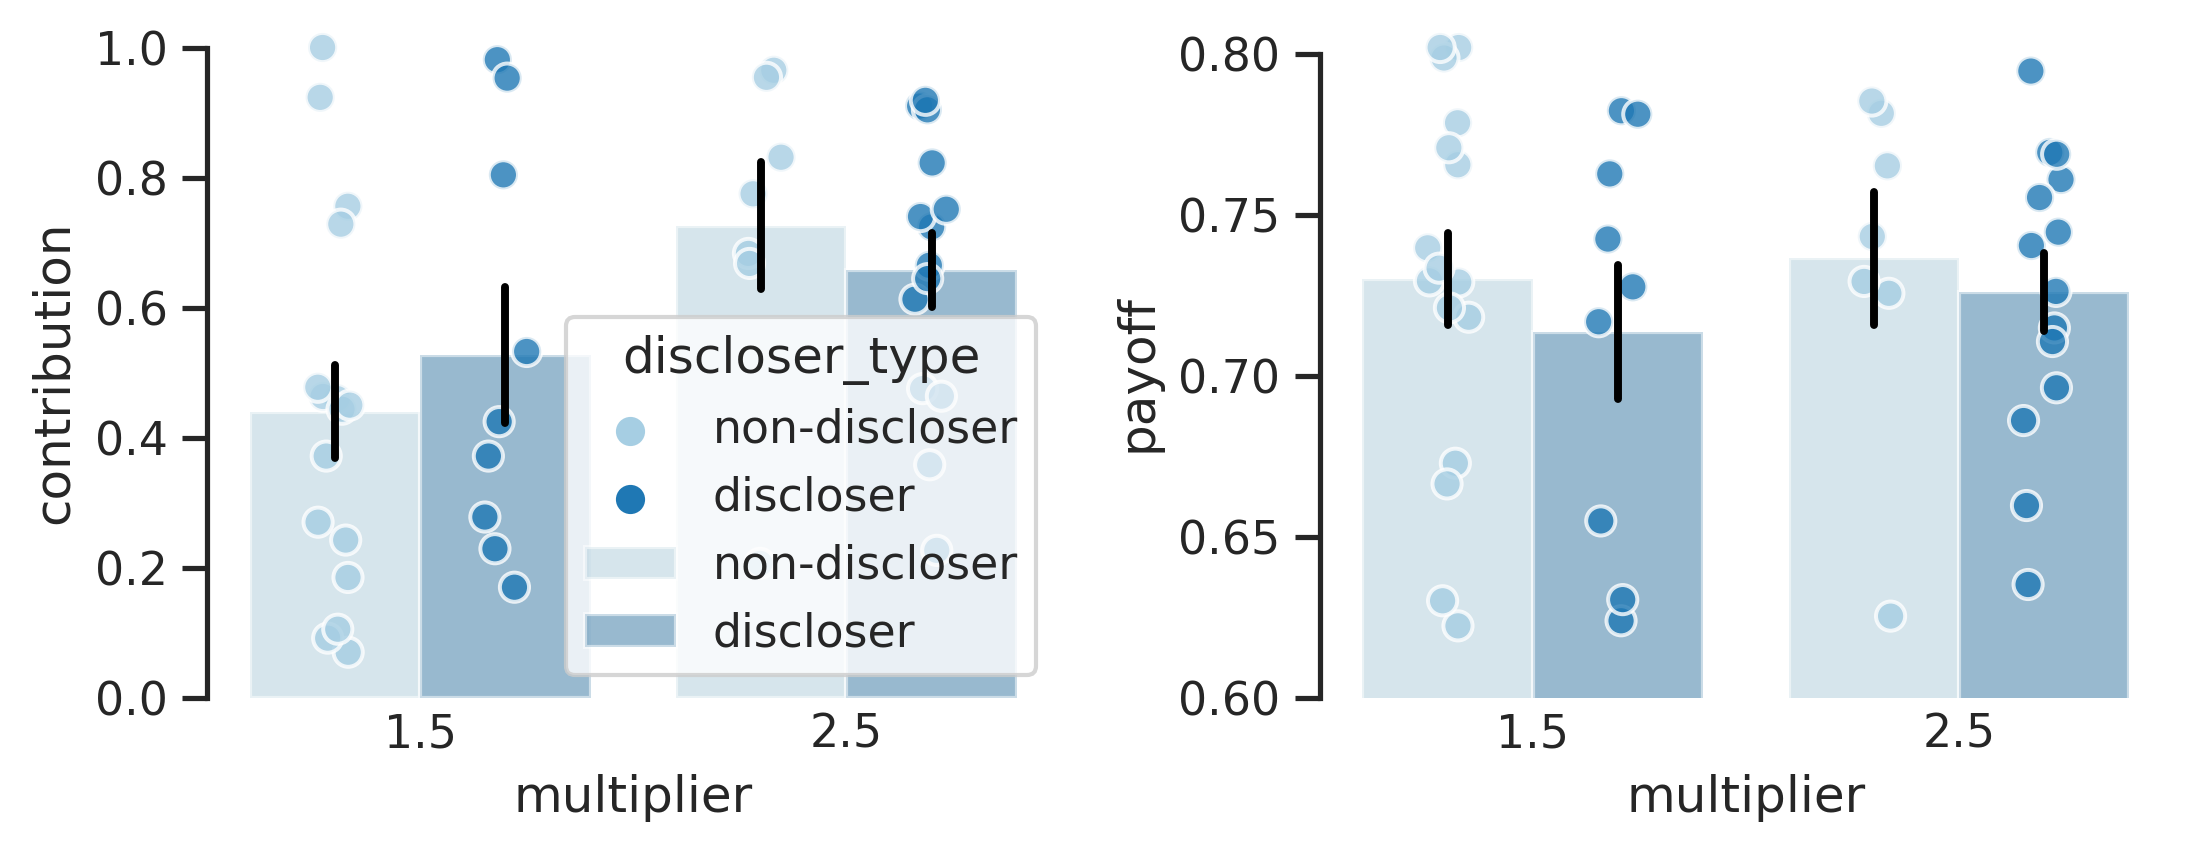

In [ ]:
selected_exp = 4
df = dfs[selected_exp].copy()
# df['norm_payoff'] = (df.norm_payoff-df.norm_payoff.min())/(df.norm_payoff.max()-df.norm_payoff.min())

sns.set({'figure.figsize':(7.5, 3), 'figure.dpi': 300})
sns.set_style('ticks')
sns.set_palette("Paired")

# --------------------------------------------------------------------------------------------------------
# Figure contribution
#---------------------------------------------------------------------------------------------------------
plt.subplot(1, 2, 1)
vd = 'norm_contribution'

df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()
# df2['norm_payoff'] = (df2.norm_payoff-df2.norm_payoff.min())/(df2.norm_payoff.max()-df2.norm_payoff.min())
med = df2.disclose.median()

df2['discloser_type'] = df2['disclose'].apply(lambda x: 'discloser' if x > med else 'non-discloser')

sns.barplot(x='multiplier', y=vd, data=df2, errorbar="se",
            edgecolor="white",
            hue='discloser_type',
            errcolor="black",
            errwidth=1.9,
            capsize = 0.00,
            alpha=0.5, zorder=0, hue_order=['non-discloser', 'discloser'])

sns.stripplot(
    x='multiplier',
    y=vd,
    hue='discloser_type',
    data=df2,
    dodge=True,
    jitter=True,
    alpha=0.8,
    size=7,
    linewidth=.95,
    edgecolor='white',
    zorder=1, hue_order=['non-discloser', 'discloser'], clip_on=False)

r = pg.ttest(x=df2[df2['discloser_type'] == 'non-discloser'][vd],
            y=df2[df2['discloser_type'] == 'discloser'][vd])
print('Variable: ', vd)
print(r)
# break
plt.ylabel('contribution')
# plt.ylim(0.6, .8)
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)
print('Variable: ', vd)
pg.anova(data=df2, dv=vd, between=['discloser_type', 'multiplier'])
# plt.legend((), (), frameon=False)
plt.ylim(0, 1)
# --------------------------------------------------------------------------------------------------------
# Figure payoff
#---------------------------------------------------------------------------------------------------------

plt.subplot(1, 2, 2)
vd = 'norm_payoff'

df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()
# df2['norm_payoff'] = (df2.norm_payoff-df2.norm_payoff.min())/(df2.norm_payoff.max()-df2.norm_payoff.min())
med = df2.disclose.median()

df2['discloser_type'] = df2['disclose'].apply(lambda x: 'discloser' if x > med else 'non-discloser')

sns.barplot(x='multiplier', y=vd, data=df2, errorbar="se",
            edgecolor="white",
            hue='discloser_type',
            errcolor="black",
            errwidth=1.9,
            capsize = 0.00,
            alpha=0.5, zorder=0, hue_order=['non-discloser', 'discloser'])

ax = sns.stripplot(
    x='multiplier',
    y=vd,
    hue='discloser_type',
    data=df2,
    dodge=True,
    jitter=True,
    alpha=0.8,
    size=7,
    linewidth=.95,
    edgecolor='white',
    zorder=1, hue_order=['non-discloser', 'discloser'], clip_on=False)

plt.ylim(df2.norm_payoff.min(), df2.norm_payoff.max())
sns.despine(bottom=True)
ax.set_yticks([0.6, 0.65, .70, .75, .80])


r = pg.ttest(x=df2[df2['discloser_type'] == 'non-discloser'][vd],
            y=df2[df2['discloser_type'] == 'discloser'][vd])
print('Variable: ', vd)
print(r)
# break
plt.ylabel('payoff')
# plt.ylim(0.6, .8)
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)

print('Variable: ', vd)
pg.anova(data=df2, dv=vd, between=['discloser_type', 'multiplier'])
plt.legend((), (), frameon=False)

plt.tight_layout()

plt.savefig(f'fig/fig2_interaction_exp{selected_exp}.svg')

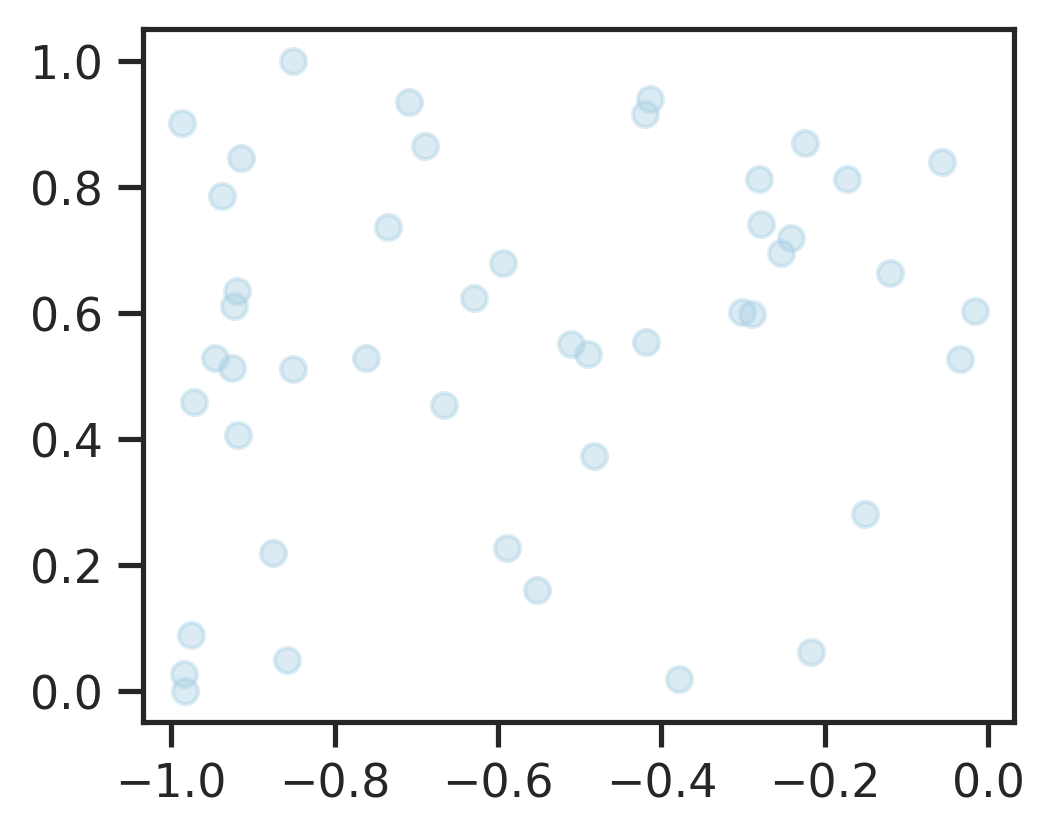

In [ ]:
s = (df.groupby('prolific_id').norm_payoff.mean()-df.groupby('prolific_id').norm_payoff.mean().min())/(df.groupby('prolific_id').norm_payoff.mean().max()-df.groupby('prolific_id').norm_payoff.mean().min())
plt.scatter(x=[0, ] * len(s) + (np.random.random(size=len(s)) -1), y=s, alpha=0.4)